Este trabalho tem como objetivo prever o número de pessoas que utilizam o metrô de Nova York. A taxa de amostragem temporal e/ou espacial deve ser determinada pelo desenvolvedor e essa decisão faz parte do desafio.

O dataset consiste em registros periódicos de entrada e saída captadas nas catracas dos metrôs.

In [0]:
# # Libs
# import numpy as np
# import pandas as pd
# import os
# import glob
# import gzip
# import pyarrow

# # Get data local file names
# path = os.getcwd() + '\\data'
# csv_files = glob.glob(os.path.join(path, "*.csv.gz"))

# # Read 2010 data to pandas df
# with open(csv_files[0], 'rb') as fd:
#     gzip_fd = gzip.GzipFile(fileobj=fd)
#     df = pd.read_csv(gzip_fd)
    
# # Append remaining years
# for i in range(1, len(csv_files)):    
#     with open(csv_files[i], 'rb') as fd:
#         gzip_fd = gzip.GzipFile(fileobj=fd)
#         new_year = pd.read_csv(gzip_fd)    
#     df = pd.concat([df, new_year])
    
# # clear index
# df = df.reset_index(drop=True)

# # Persist as parquet file
# df.to_parquet('df_parquet.parquet')

A célula comentada acima é o código que representa o único step realizado nos dados antes do load abaixo. Ela foi rodada em Python em um Jupyter notebook.

#### Libs n funcs

In [0]:
import numpy as np
import pandas as pd
from pandas.tseries.holiday import USFederalHolidayCalendar
from xgboost import XGBRegressor
from datetime import datetime
from datetime import timedelta
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from pyspark.sql.functions import rand
from sklearn.metrics import mean_absolute_error

In [0]:
## FUNÇÕES OBSOLETAS

def generate_data(df_pd, station_column_name, data_inicio, dias_a_prever):
  # Create date column
  inicio = datetime.strptime(data_inicio, '%Y-%m-%d')
  date_list = [inicio + timedelta(days=x) for x in range(dias_a_frente)]
  date_list = pd.DataFrame(date_list)
  date_list.columns = (['date'])

  # Create station column
  station_data = pd.DataFrame(df_pd[station_column_name].unique())
  station_data.columns = ([station_column_name])

  # Explode date by station
  test_set = pd.DataFrame([])
  for i in range(0, len(station_data)):
    station_number = station_data[station_column_name][i]
    station = pd.DataFrame(np.full(shape=len(date_list), fill_value=station_number , dtype=np.int))
    station.columns = ([station_column_name])
    cob = pd.concat([date_list, station], axis=1)
    test_set = test_set.append(cob)
  test_set = test_set.reset_index(drop=True)

  # Create date features
  test_set['day_of_week'] = test_set['date'].dt.dayofweek
  test_set['day_of_month'] = test_set['date'].dt.day
  test_set['day_of_year'] = test_set['date'].dt.dayofyear
  test_set['month'] = test_set['date'].dt.month
  test_set['quarter'] = test_set['date'].dt.quarter
  test_set['week_of_year'] = test_set['date'].dt.weekofyear
  test_set['year'] = test_set['date'].dt.year

  # Season
  spring = (range(80, 172)) # 1
  summer = range(172, 264) # 2
  fall = range(264, 355) # 3
  def set_season(df):
      if df['day_of_year'] in spring:
          return 1
      elif df['day_of_year'] in summer:
          return 2
      elif df['day_of_year'] in fall:
          return 3
      else:
          return 4
  test_set = test_set.assign(season=test_set.apply(set_season, axis=1))

  # Holidays
  holidays = cal.holidays(start=inicio, end=inicio + timedelta(days=dias_a_frente)).to_pydatetime()
  holidays = pd.DataFrame(holidays)
  holidays['holiday'] = 1
  holidays.columns = (['date', 'holiday'])
  test_set = pd.merge(test_set, holidays, on='date', how='left')
  test_set['holiday'] = test_set['holiday'].fillna(0)
  
  return test_set


def flow_per_day(model, test_set, df_pd, time_to_start_view):
  yhat = model.predict(np.array(test_set.iloc[:, 1:]))
  yhat = pd.DataFrame(yhat)
  predicted_data = pd.concat([test_set, yhat], axis=1)
  predicted_data.rename(columns={0:'flow'}, inplace=True)
  predicted_data = predicted_data.groupby('date')['flow'].sum().reset_index()

  real_date = df_pd.groupby('date')['flow'].sum().reset_index()

  plt.figure(figsize=(16, 6))
  plt.plot(real_date['date'][real_date['date'] >= time_limit], real_date['flow'][real_date['date'].dt.year >= 2017], label='Real Flow per day')
  plt.plot(predicted_data['date'], predicted_data['flow'], label='Predicted Flow per day')
  plt.title('Fluxo diário', size = 15)
  plt.xlabel('Day', size = 15)
  plt.ylabel('Flow', size = 15)
  plt.legend()
  plt.grid()
  plt.show()
  return predicted_data


def flow_per_station_per_day(model, test_set, df_pd, station_rank_limit, time_to_start_view):
  yhat = model.predict(np.array(test_set.iloc[:, 1:]))
  yhat = pd.DataFrame(yhat)
  predicted_data = pd.concat([test_set, yhat], axis=1)
  predicted_data.rename(columns={0:'flow'}, inplace=True)
  predicted_data = predicted_data[['date', 'station_index', 'flow']]

  real_data = df_pd[['date', 'station_index', 'flow']]

  validation_data = pd.concat([real_data, predicted_data])

  validation_data = pd.merge(validation_data, top_stations[['station_index', 'rank']], on='station_index', how='left')

  validation_data = validation_data[validation_data['date'] >= time_to_start_view]

  plt.figure(figsize=(16, 6))
  sns.lineplot(data = validation_data[validation_data['rank'] <= station_rank_limit], x='date', y='flow', hue='rank')
  plt.axvline(datetime.strptime('2017-09-23', '%Y-%m-%d'), color='red')
  plt.grid()
  plt.plot()

  return validation_data

#### EDA

In [0]:
df = spark.read.parquet(_data_science + 'vitor/etc/df_parquet.parquet')
df.createOrReplaceTempView('df')
display(df.limit(10))

time,ca,unit,scp,station,linename,division,desc,entries,exits
2010-04-17 04:00:00,A002,R051,02-00-00,LEXINGTON AVE,456NQR,BMT,REGULAR,2704717.0,928793.0
2010-04-17 04:00:00,A002,R051,02-00-01,LEXINGTON AVE,456NQR,BMT,REGULAR,2697632.0,566683.0
2010-04-17 04:00:00,A002,R051,02-03-00,LEXINGTON AVE,456NQR,BMT,REGULAR,1127722.0,3943492.0
2010-04-17 04:00:00,A002,R051,02-03-01,LEXINGTON AVE,456NQR,BMT,REGULAR,2425570.0,3733289.0
2010-04-17 04:00:00,A002,R051,02-03-02,LEXINGTON AVE,456NQR,BMT,REGULAR,2214633.0,3021589.0
2010-04-17 04:00:00,A002,R051,02-03-03,LEXINGTON AVE,456NQR,BMT,REGULAR,1958493.0,2575465.0
2010-04-17 04:00:00,A002,R051,02-03-04,LEXINGTON AVE,456NQR,BMT,REGULAR,2557379.0,1751238.0
2010-04-17 04:00:00,A002,R051,02-03-05,LEXINGTON AVE,456NQR,BMT,REGULAR,4325004.0,907884.0
2010-04-17 04:00:00,A002,R051,02-03-06,LEXINGTON AVE,456NQR,BMT,REGULAR,3281631.0,409266.0
2010-04-17 04:00:00,A002,R051,02-05-00,LEXINGTON AVE,456NQR,BMT,REGULAR,500.0,0.0


In [0]:
%sql

select
  station
  , datediff(max(cast(time as date)), min(cast(time as date))) as station_measure_total_days
  from
    df
  group by 1
  order by 2 asc
  limit 10

station,station_measure_total_days
LGA AIRPORT CTB,1
86 ST-2 AVE,266
96 ST-2 AVE,266
72 ST-2 AVE,266
PATH NEW WTC,372
NASSAU ST,427
BARCLAYS CENTER,441
BAY RIDGE AV,492
3 AV,637
AVENUE M,637


As estações possuem intervalos de mensuração diferentes. Vou precisar lembrar disso antes de splitar meus dados.

In [0]:
print('shape:', df.count(), ',', len(df.columns))
print('partitions:', df.rdd.getNumPartitions())

shape: 79609191 , 10
partitions: 8

In [0]:
%sql

select
  max(cast(time as date))
  , min(cast(time as date))
  , count(distinct time)
  , count(distinct ca)
  , count(distinct scp)
  , count(distinct station)
  , count(distinct linename)
  , count(distinct division)
  , count(distinct desc)
  , count(distinct entries)
  , count(distinct exits)
  from
    df

max(CAST(time AS DATE)),min(CAST(time AS DATE)),count(DISTINCT time),count(DISTINCT ca),count(DISTINCT scp),count(DISTINCT station),count(DISTINCT linename),count(DISTINCT division),count(DISTINCT desc),count(DISTINCT entries),count(DISTINCT exits)
2017-09-23,2010-04-17,8510420,754,304,574,129,6,25,14278746,12727727


In [0]:
%sql

select
  station
  , count(distinct linename)
  , count(distinct division)
  from
    df
  group by 1
  order by 2 desc
  limit 5

station,count(DISTINCT linename),count(DISTINCT division)
23 ST,6,3
59 ST,6,2
14 ST-UNION SQ,5,2
86 ST,5,3
42 ST-PORT AUTH,4,1


.

##### Decidi por medir a quantidade de pessoas que utilizam cada estação por dia.

O primeiro passo é definir qual é a variável target, e entender como as outras informações se comportam ao seu redor.<br>
Essa variável é a coluna 'flow' e é calculada abaixo.<br>
Vou agrupar os dados por dia e pelas unidades fisicas.

In [0]:
%sql

select
  station
  , ca
  , unit
  , scp
  , cast(time as date) as date
  , max(entries) - min(entries) as entries
  , max(exits) - min(exits) as exits
  , (max(entries) - min(entries)) + (max(exits) - min(exits)) as flow
  from
    df
  group by 1, 2, 3, 4, 5
  order by entries desc
  limit 10

station,ca,unit,scp,date,entries,exits,flow
FULTON ST,R206,R014,02-05-01,2014-10-11,2.862953728E9,6.51427328E8,3.514381056E9
42 ST-TIMES SQ,R148,R033,01-00-01,2014-10-11,2.79080992E9,1.00000048E9,3.7908104E9
BROOKLYN BRIDGE,R210,R044,00-03-04,2014-10-11,2.723468096E9,1.000000363E9,3.723468459E9
23 ST-6 AVE,N508,R453,00-00-02,2014-10-11,2.656745216E9,1.000000576E9,3.656745792E9
GRD CNTRL-42 ST,R238A,R046,02-00-03,2016-10-03,2.147369278E9,36243.0,2.147405521E9
JAY ST-METROTEC,N103,R127,00-02-00,2016-07-21,2.142849068E9,7.0022295E7,2.212871363E9
LORIMER ST,J005,R353,00-00-01,2016-04-06,2.130765584E9,2.097169658E9,4.227935242E9
14 ST,N078,R175,01-03-00,2017-01-22,2.12219288E9,1.145297208E9,3.267490088E9
TREMONT AVE,N213,R154,00-06-01,2014-11-01,2.119828244E9,7.71275065E8,2.891103309E9
34 ST-HERALD SQ,A025,R023,01-03-02,2014-10-11,2.119046272E9,2.000001484E9,4.119047756E9


In [0]:
df_1 = spark.sql("""
select
  station
  , ca
  , unit
  , scp
  , cast(time as date) as date
  , max(entries) - min(entries) as entries
  , max(exits) - min(exits) as exits
  , (max(entries) - min(entries)) + (max(exits) - min(exits)) as flow
  from
    df
  group by 1, 2, 3, 4, 5
  order by entries desc
""")

df_1_pd = df_1.select('entries', 'exits').toPandas()

In [0]:
df_1_pd.sort_values('entries', ascending=False).head(10)

Out[68]:

,entries,exits
0,2.862954e+09,6.514273e+08
1,2.790810e+09,1.000000e+09
2,2.723468e+09,1.000000e+09
3,2.656745e+09,1.000001e+09
4,2.147369e+09,3.624300e+04
5,2.142849e+09,7.002230e+07
6,2.130766e+09,2.097170e+09
7,2.122193e+09,1.145297e+09
8,2.119828e+09,7.712751e+08
9,2.119046e+09,2.000001e+09


Temos medições de entrada de quase 3 bilhões de pessoas em um mesmo dia.<br>
Preciso me livrar dessa medições erradas, vamos analisar a distribuição desses valores.

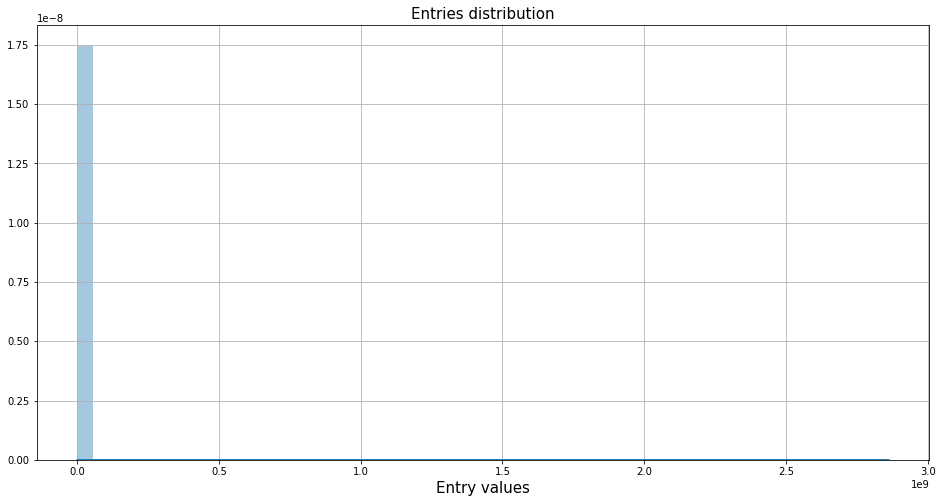

In [0]:
fig = plt.figure(figsize=(16,8))
ax = sns.distplot(df_1_pd['entries'])
plt.title('Entries distribution', size = 15)
plt.xlabel('Entry values', size = 15)
plt.grid()
plt.show()

O gráfico acima não me ajuda, os valores estão muito distantes, preciso reduzir o domínio.<br>
Após algumas análises consegui entender melhor a distribuição das entradas e saídas usando os quartiles.

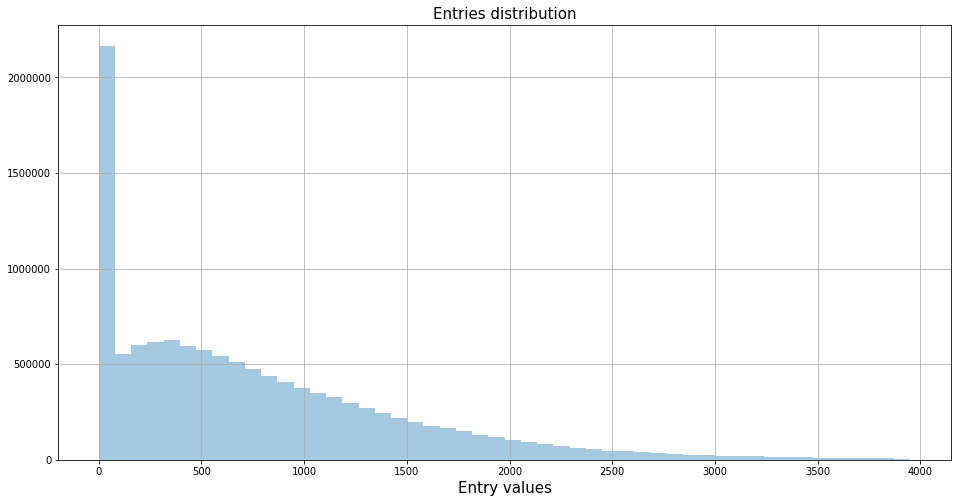

In [0]:
fig = plt.figure(figsize=(16,8))
entries_quartile_filter = df_1_pd['entries'][df_1_pd['entries'] < df_1_pd.entries.quantile(0.995)]
ax = sns.distplot(entries_quartile_filter, kde=False)
plt.title('Entries distribution', size = 15)
plt.xlabel('Entry values', size = 15)
plt.grid()
plt.show()

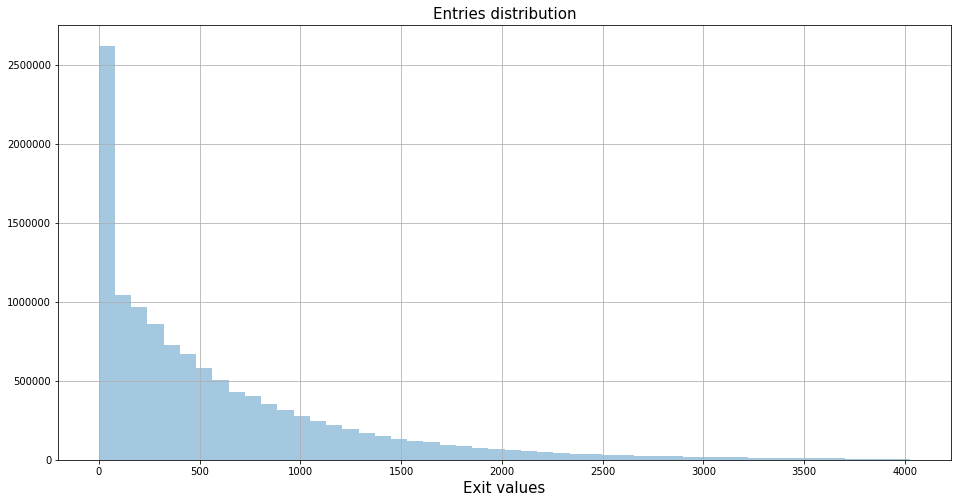

In [0]:
fig = plt.figure(figsize=(16,8))
exits_quartile_filter = df_1_pd['exits'][df_1_pd['exits'] < df_1_pd.exits.quantile(0.995)]
ax = sns.distplot(exits_quartile_filter, kde=False)
plt.title('Entries distribution', size = 15)
plt.xlabel('Exit values', size = 15)
plt.grid()
plt.show()

Seria interessante fazer um trabalho para substituir esses valores errados de medição. Algo parecido com pegar a media dos valores historicos de dias cujo a data é semelhante à da medição errônea.<br>
Entretanto isso ficará para um possível próximo aprofundamento.<br>
Por hora vou apenas dropar essas linhas, por sorte ou não elas representam aproximadamente apenas 0,5% do volume de total de dados até esse ponto.<br>

In [0]:
# Values to filter

print('entry_filter:', df_1_pd.entries.quantile(0.995))
print('exit_filter:', df_1_pd.exits.quantile(0.995))

entry_filter: 3952.0
exit_filter: 4028.0

In [0]:
%sql

with calc as
(
select
  station
  , ca
  , unit
  , scp
  , cast(time as date) as date
  , max(entries) - min(entries) as entries
  , max(exits) - min(exits) as exits
  , (max(entries) - min(entries)) + (max(exits) - min(exits)) as flow
  from
    df
    where station is not null
    and cast(time as date) is not null
  group by 1, 2, 3, 4, 5
  order by entries desc
)

select
  *
  from
    calc
    where entries < 3952
    and exits < 4028
limit 10

station,ca,unit,scp,date,entries,exits,flow
14 ST-UNION SQ,A033,R170,02-00-05,2015-03-17,3951.0,2204.0,6155.0
HOYT ST-ASTORIA,R514,R094,00-00-03,2012-11-27,3951.0,191.0,4142.0
34 ST-PENN STA,R138,R293,00-00-00,2014-11-06,3951.0,2221.0,6172.0
ROOSEVELT AVE,N324,R018,00-06-02,2010-11-11,3951.0,540.0,4491.0
14 ST-UNION SQ,R221,R170,01-00-01,2013-04-25,3951.0,1666.0,5617.0
UNION TPK-KEW G,N336,R158,00-00-04,2014-04-08,3951.0,335.0,4286.0
JAMAICA 179 ST,N343,R019,00-00-09,2017-01-18,3951.0,59.0,4010.0
34 ST-HERALD SQ,N507,R023,00-03-06,2014-07-31,3951.0,97.0,4048.0
77 ST,R248,R178,00-00-07,2011-09-27,3951.0,441.0,4392.0
34 ST-HERALD SQ,N507,R023,00-03-05,2012-08-08,3951.0,237.0,4188.0


Vou usar um criar um modelo de regressão para prever futuros fluxos por estação por dia. Sendo assim, existem 3 variáveis indispensáveis para mim neste momento: 'station', 'date' e 'flow'.

As colunas 'entries' e exit serão dropadas a partir daqui, entendo que não são mais úteis.

Sobre as colunas 'ca', 'unit' e 'scp', talvez haja algo mais interessante a fazer com elas do que dropá-las aqui. Certamente eu precisaria realizar um pouco mais de EDA para entender como transformá-las em features inerentes às estações. Penso que seria interessante por exemplo pivotear todos os valores distintos da coluna 'linename', criando uma coluna para cada trem, a estação recebe 1 quando atende a aquele trem e 0 caso contrario.<br>
Entretanto essas ideias também ficarão para um possível próximo aprofundamento!<br>
Por hora, vou dropar essas colunas também.

A coluna flow será mantida exatamente como está.

Para a coluna 'station', vou mantêla e fazer um "One-hot encoding" manual utilizando a função rank() do sql, visto que meu modelo não aceita strings.

A coluna 'date' será mantida para futuros joins, mas será dissolvida em features para alimentar o modelo.

Também já vou agrupar meus dados pelo meu objetivo: data e station.

As mudanças entram na próxima query.

In [0]:
# Get US federal holiday data

cal = USFederalHolidayCalendar()
holidays = cal.holidays(start='2010-04-17', end='2017-09-23').to_pydatetime()
holidays = pd.DataFrame(holidays)
holidays['holiday'] = 1
holidays.columns = (['date', 'holiday'])
holidays = spark.createDataFrame(holidays)
holidays.createOrReplaceTempView('holidays')
display(holidays.head(10))

date,holiday
2010-05-31T00:00:00.000+0000,1
2010-07-05T00:00:00.000+0000,1
2010-09-06T00:00:00.000+0000,1
2010-10-11T00:00:00.000+0000,1
2010-11-11T00:00:00.000+0000,1
2010-11-25T00:00:00.000+0000,1
2010-12-24T00:00:00.000+0000,1
2010-12-31T00:00:00.000+0000,1
2011-01-17T00:00:00.000+0000,1
2011-02-21T00:00:00.000+0000,1


In [0]:
query = """
with calc as
(
select
  station
  , ca
  , unit
  , scp
  , cast(time as date) as date
  , max(entries) - min(entries) as entries
  , max(exits) - min(exits) as exits
  , (max(entries) - min(entries)) + (max(exits) - min(exits)) as flow
  from
    df
    where station is not null
    and cast(time as date) is not null
  group by 1, 2, 3, 4, 5
),

calc2 as
(
select
  calc.date
  , station  
  , sum(calc.flow) as flow
  from
    calc
    where calc.entries < 3952
    and calc.exits < 4028
  group by 1, 2
)

select
  calc2.date
  , calc2.station
  , cast(rank() over(order by station asc) as int) as station_index
  , weekday(calc2.date) day_of_week
  , dayofmonth(calc2.date) as day_of_month
  , dayofyear(calc2.date) as day_of_year
  , month(calc2.date) as month
  , quarter(calc2.date) as quarter
  , weekofyear(calc2.date) as week_of_year
  , year(calc2.date) as year
  , case
    when dayofyear(calc2.date) >= 80 and dayofyear(calc2.date) < 172 then 1 -- usa spring
    when dayofyear(calc2.date) >= 172 and dayofyear(calc2.date) < 264 then 2 -- usa summer
    when dayofyear(calc2.date) >= 264 and dayofyear(calc2.date) < 355 then 3 -- usa fall
    else 4 -- usa winter
    end
      as season
  , cast(ifnull(holidays.holiday, 0) as int) as holiday
  , flow
  from
    calc2
    left join holidays
      on calc2.date = cast(holidays.date as date)
"""

df_2 = spark.sql(query)
df_2_pd = df_2.toPandas()
df_2_pd['date'] = pd.to_datetime(df_2_pd['date'])
display(df_2.limit(10))

date,station,station_index,day_of_week,day_of_month,day_of_year,month,quarter,week_of_year,year,season,holiday,flow
2017-02-02,1 AV,1,3,2,33,2,1,5,2017,4,0,33139.0
2016-05-06,1 AV,1,4,6,127,5,2,18,2016,1,0,33119.0
2016-10-19,1 AV,1,2,19,293,10,4,42,2016,3,0,33909.0
2016-11-26,1 AV,1,5,26,331,11,4,47,2016,3,0,18856.0
2016-12-25,1 AV,1,6,25,360,12,4,51,2016,4,0,10506.0
2017-06-15,1 AV,1,3,15,166,6,2,24,2017,1,0,32867.0
2016-08-23,1 AV,1,1,23,236,8,3,34,2016,2,0,27479.0
2017-02-10,1 AV,1,4,10,41,2,1,6,2017,4,0,30580.0
2016-10-21,1 AV,1,4,21,295,10,4,42,2016,3,0,29839.0
2017-02-21,1 AV,1,1,21,52,2,1,8,2017,4,0,26870.0


Vou adicionar uma coluna que é o rank de fluxo por estação, isso vai me ajudar a gerar alguns gráficos.<br>
Vamos analisar o comportamento de algumas variáveis de tempo em relação ao fluxo...

In [0]:
df_2_pd.shape

Out[79]: (1018591, 13)

In [0]:
# Calculate top flows per station

top_stations = df_2_pd.groupby(['station', 'station_index'])['flow'].sum().reset_index().sort_values('flow', ascending=False).reset_index(drop=True)
top_stations['rank'] = np.arange(1, 575, 1)
top_stations.head(10)

Out[92]:

,station,station_index,flow,rank
0,34 ST-PENN STA,176877,479611265.0,1
1,34 ST-HERALD SQ,173387,315205870.0,2
2,14 ST-UNION SQ,45977,294446131.0,3
3,86 ST,302279,258177755.0,4
4,125 ST,28397,243484660.0,5
5,42 ST-GRD CNTRL,191639,241981220.0,6
6,42 ST-TIMES SQ,196400,224705055.0,7
7,23 ST,136283,223712423.0,8
8,CANAL ST,465424,207657649.0,9
9,42 ST-PA BUS TE,193694,206092368.0,10


In [0]:
df_2_pd = pd.merge(df_2_pd, top_stations[['station_index', 'rank']], on='station_index', how='left')

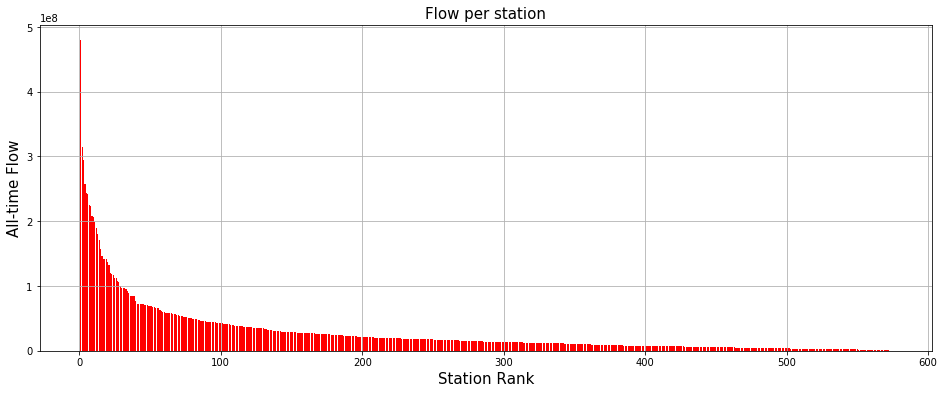

In [0]:
plt.figure(figsize=(16, 6))
plt.bar(top_stations['rank'], top_stations['flow'], color='red') # Ou essa cor está bugada ou acabei de descobri um problema.
plt.title('Flow per station', size = 15)
plt.xlabel('Station Rank', size = 15)
plt.ylabel('All-time Flow', size = 15)
plt.grid()
plt.show()

No handles with labels found to put in legend.

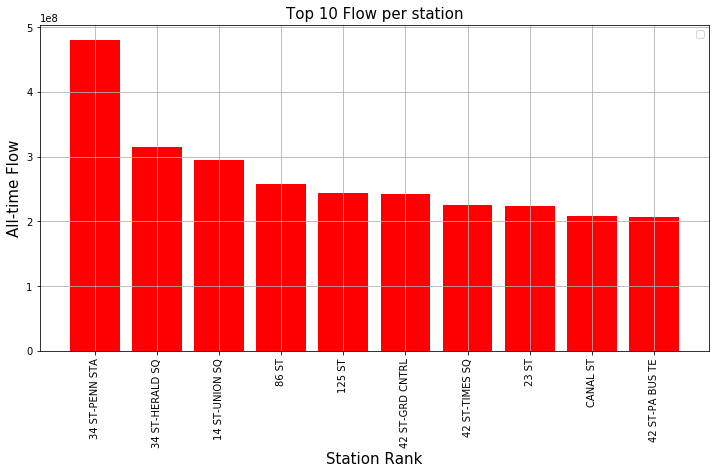

In [0]:
plt.figure(figsize=(12, 6))
plt.bar(top_stations['station'][top_stations['rank'] <= 10], top_stations['flow'][top_stations['rank'] <= 10], color='red', )
plt.title('Top 10 Flow per station', size = 15)
plt.xlabel('Station Rank', size = 15)
plt.xticks(rotation=90, size=10)
plt.ylabel('All-time Flow', size = 15)
plt.legend()
plt.grid()
plt.show()

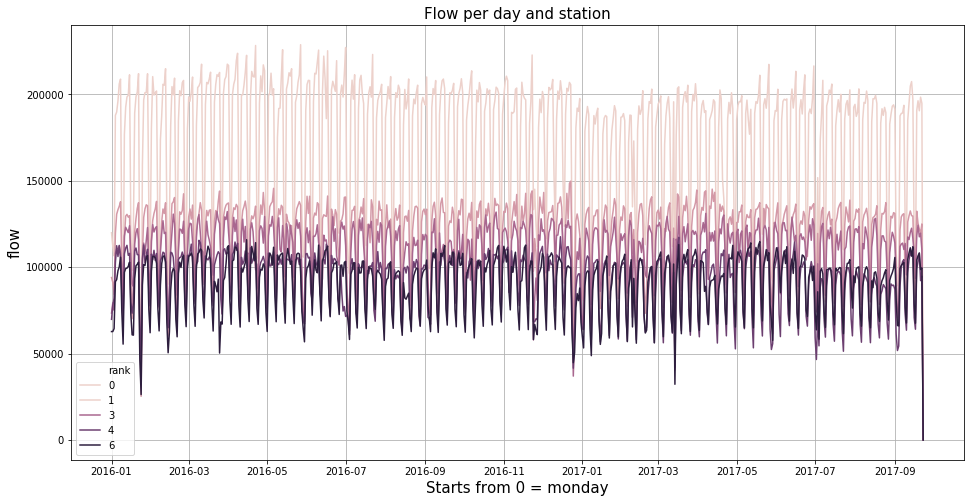

In [0]:
fig = plt.figure(figsize=(16,8))
sns.lineplot(data = df_2_pd[(df_2_pd['rank'] <= 5) & (df_2_pd['date'].dt.year >= 2016)], x='date', y='flow', hue='rank')
plt.title('Flow per day and station', size = 15)
plt.xlabel('Starts from 0 = monday', size = 15)
plt.ylabel('flow', size = 15)
plt.grid()
plt.show()

In [0]:
## calculate weekday's flow

flow_per_weekday = df_2_pd.groupby('day_of_week')['flow'].sum().reset_index()

flow_per_weekday_and_station = df_2_pd.groupby(['day_of_week', 'station_index'])['flow'].sum().reset_index()
flow_per_weekday_and_station = pd.merge(flow_per_weekday_and_station, top_stations[['station_index', 'rank']], on='station_index', how='left')

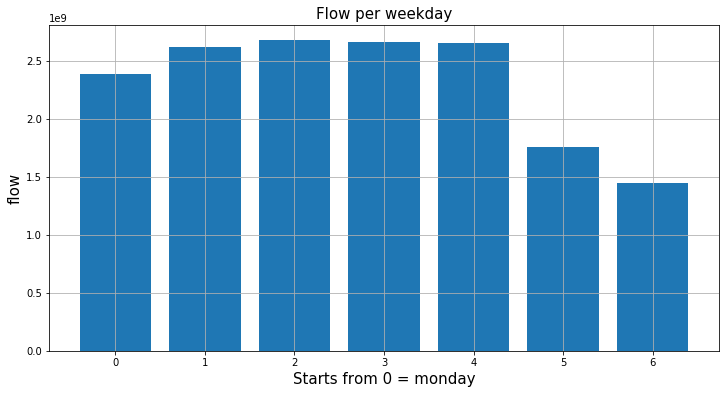

In [0]:
fig = plt.figure(figsize=(12,6))
plt.bar(flow_per_weekday['day_of_week'], flow_per_weekday['flow'])
plt.title('Flow per weekday', size = 15)
plt.xlabel('Starts from 0 = monday', size = 15)
plt.ylabel('flow', size = 15)
plt.grid()
plt.show()

Vemos que realmente o fluxo cái nos fim de semana. Vou acreditar que acontece a mesma coisa para os feriados.<br>
Vamos ver como o fluxo se comporta para as top 10 stations.

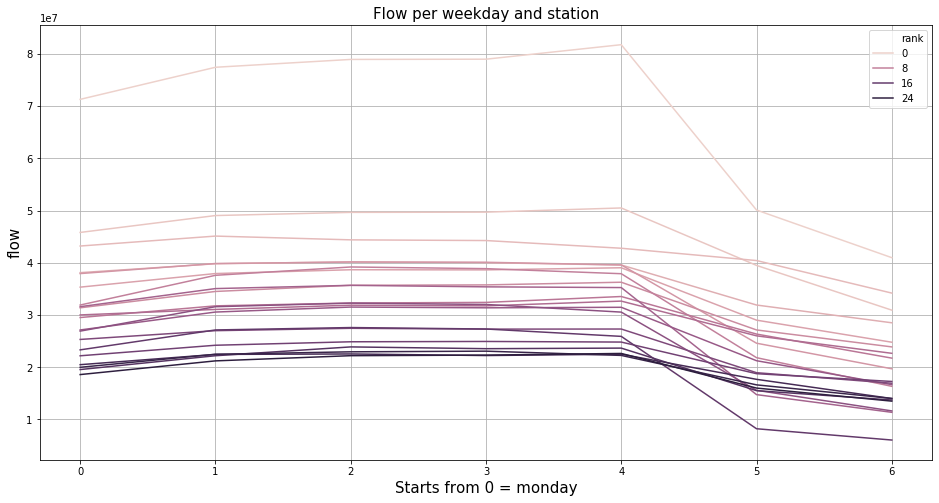

In [0]:
fig = plt.figure(figsize=(16,8))
sns.lineplot(data = flow_per_weekday_and_station[flow_per_weekday_and_station['rank'] <= 20], x='day_of_week', y='flow', hue='rank')
plt.title('Flow per weekday and station', size = 15)
plt.xlabel('Starts from 0 = monday', size = 15)
plt.ylabel('flow', size = 15)
plt.grid()
plt.show()

Realmente o fluxo conversa bem com weekday.<br>
Vamos ver se existe diferença entre fluxos por estação do ano.

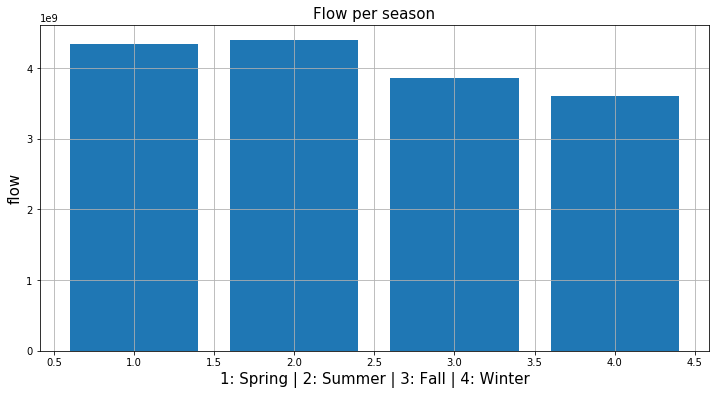

In [0]:
flow_per_season = df_2_pd.groupby('season')['flow'].sum().reset_index()

fig = plt.figure(figsize=(12,6))
plt.bar(flow_per_season['season'], flow_per_season['flow'])
plt.title('Flow per season', size = 15)
plt.xlabel('1: Spring | 2: Summer | 3: Fall | 4: Winter', size = 15)
plt.ylabel('flow', size = 15)
plt.grid()
plt.show()

Certamente cabe um trabalho mais aprofundado dos dados, mas para o objetivo proposto estou satisfeito.<br>
Vou utilizar praticamente todos processamentos realizados nos dados até a criação do df_2.

Abaixo vou separar os dados originais em training (80%) e validation set (20%) e submetê-los às etapas de processamento idênticas.

#### Pre processing

A única coisa que vou fazer no DF antes do split é calcular os valores inteiros para cada station (string). Se eu fizer isso depois do split provavelmente vai dar errado.

In [0]:
station_data = spark.sql("""
with calc as
(
select
  *
  , cast(dense_rank() over(order by station asc) as int) as station_index
  from
    df
    where station is not null
)

select distinct
  station
  , station_index
  from
    calc""")

station_data.createOrReplaceTempView('station_data')

In [0]:
query = """
with calc as
(
select
  station
  , datediff(max(cast(time as date)), min(cast(time as date))) as station_measure_total_days
  from
    df
  group by 1
  order by 2 desc
),

calc2 as
(
select
  df.*
  , calc.station_measure_total_days
  , dense_rank() over(partition by df.station order by cast(df.time as date) asc) as station_day_count
  from
    df
    left join
      calc
        on df.station = calc.station
    where df.station != 'LGA AIRPORT CTB'
)

select
  calc2.*
  , case when calc2.station_day_count <= calc2.station_measure_total_days * 0.8 then 'train'
         else 'test'
         end as split_filter
  from
    calc2
"""

df_to_split = spark.sql(query)

In [0]:
df_train = df_to_split.filter(df_to_split["split_filter"] == 'train')
df_test = df_to_split.filter(df_to_split["split_filter"] == 'test')

In [0]:
# df_train, df_test = df.randomSplit([0.8, 0.2], seed=42)

In [0]:
df_count = df.count()
df_train_count = df_train.count()
df_test_count = df_test.count()

In [0]:
print('df_count', df_count)
print('perc_training_set', round(df_train_count/df_count, 2))
print('perc_test_set', round(df_test_count/df_count, 2))

df_count 79609191
perc_training_set 0.82
perc_test_set 0.18

In [0]:
df_train.createOrReplaceTempView('df_train')
df_test.createOrReplaceTempView('df_test')

In [0]:
# Processing TRAINING set

query = """
with calc as
(
select
  station
  , ca
  , unit
  , scp
  , cast(time as date) as date
  , max(entries) - min(entries) as entries
  , max(exits) - min(exits) as exits
  , (max(entries) - min(entries)) + (max(exits) - min(exits)) as flow
  from
    df_train
    where station is not null
    and cast(time as date) is not null
  group by 1, 2, 3, 4, 5
),

calc2 as
(
select
  calc.date
  , station  
  , sum(calc.flow) as flow
  from
    calc
    where calc.entries < 3952
    and calc.exits < 4028
  group by 1, 2
)

select
  calc2.date
  , station_data.station_index
  , weekday(calc2.date) day_of_week
  , dayofmonth(calc2.date) as day_of_month
  , dayofyear(calc2.date) as day_of_year
  , month(calc2.date) as month
  , quarter(calc2.date) as quarter
  , weekofyear(calc2.date) as week_of_year
  , year(calc2.date) as year
  , case
    when dayofyear(calc2.date) >= 80 and dayofyear(calc2.date) < 172 then 1 -- usa spring
    when dayofyear(calc2.date) >= 172 and dayofyear(calc2.date) < 264 then 2 -- usa summer
    when dayofyear(calc2.date) >= 264 and dayofyear(calc2.date) < 355 then 3 -- usa fall
    else 4 -- usa winter
    end
      as season
  , cast(ifnull(holidays.holiday, 0) as int) as holiday
  , flow
  from
    calc2
    left join holidays
      on calc2.date = cast(holidays.date as date)
    left join station_data
      on calc2.station = station_data.station
"""

df_train = spark.sql(query)
df_train_pd = df_train.toPandas()
df_train_pd.head(10)

Out[97]:

,date,station_index,day_of_week,day_of_month,day_of_year,month,quarter,week_of_year,year,season,holiday,flow
0,2015-12-26,208,5,26,360,12,4,52,2015,4,0,5553.0
1,2015-12-27,208,6,27,361,12,4,52,2015,4,0,7533.0
2,2015-12-28,208,0,28,362,12,4,53,2015,4,0,12848.0
3,2015-12-29,208,1,29,363,12,4,53,2015,4,0,13674.0
4,2015-12-30,208,2,30,364,12,4,53,2015,4,0,13756.0
5,2015-12-31,208,3,31,365,12,4,53,2015,4,0,12594.0
6,2016-01-01,208,4,1,1,1,1,53,2016,4,1,7816.0
7,2016-01-02,208,5,2,2,1,1,53,2016,4,0,7956.0
8,2016-01-03,208,6,3,3,1,1,53,2016,4,0,7759.0
9,2016-01-04,208,0,4,4,1,1,1,2016,4,0,14098.0


In [0]:
# Processing TEST set

query = """
with calc as
(
select
  station
  , ca
  , unit
  , scp
  , cast(time as date) as date
  , max(entries) - min(entries) as entries
  , max(exits) - min(exits) as exits
  , (max(entries) - min(entries)) + (max(exits) - min(exits)) as flow
  from
    df_test
    where station is not null
    and cast(time as date) is not null
  group by 1, 2, 3, 4, 5
),

calc2 as
(
select
  calc.date
  , station  
  , sum(calc.flow) as flow
  from
    calc
    where calc.entries < 3952
    and calc.exits < 4028
  group by 1, 2
)

select
  calc2.date
  , station_data.station_index
  , weekday(calc2.date) day_of_week
  , dayofmonth(calc2.date) as day_of_month
  , dayofyear(calc2.date) as day_of_year
  , month(calc2.date) as month
  , quarter(calc2.date) as quarter
  , weekofyear(calc2.date) as week_of_year
  , year(calc2.date) as year
  , case
    when dayofyear(calc2.date) >= 80 and dayofyear(calc2.date) < 172 then 1 -- usa spring
    when dayofyear(calc2.date) >= 172 and dayofyear(calc2.date) < 264 then 2 -- usa summer
    when dayofyear(calc2.date) >= 264 and dayofyear(calc2.date) < 355 then 3 -- usa fall
    else 4 -- usa winter
    end
      as season
  , cast(ifnull(holidays.holiday, 0) as int) as holiday
  , flow
  from
    calc2
    left join holidays
      on calc2.date = cast(holidays.date as date)
    left join station_data
      on calc2.station = station_data.station
"""

df_test = spark.sql(query)
df_test_pd = df_test.toPandas()
df_test_pd.head(10)

Out[98]:

,date,station_index,day_of_week,day_of_month,day_of_year,month,quarter,week_of_year,year,season,holiday,flow
0,2017-01-22,208,6,22,22,1,1,3,2017,4,0,4295.0
1,2017-01-23,208,0,23,23,1,1,4,2017,4,0,8003.0
2,2017-01-24,208,1,24,24,1,1,4,2017,4,0,8315.0
3,2017-01-25,208,2,25,25,1,1,4,2017,4,0,8796.0
4,2017-01-26,208,3,26,26,1,1,4,2017,4,0,8803.0
5,2017-01-27,208,4,27,27,1,1,4,2017,4,0,8595.0
6,2017-01-28,208,5,28,28,1,1,4,2017,4,0,5425.0
7,2017-01-29,208,6,29,29,1,1,4,2017,4,0,4548.0
8,2017-01-30,208,0,30,30,1,1,5,2017,4,0,7978.0
9,2017-01-31,208,1,31,31,1,1,5,2017,4,0,9180.0


In [0]:
model = XGBRegressor()
model = XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1, subsample=0.8, colsample_bytree=0.8)

In [0]:
X_train, y_train, X_test, y_test = np.array(df_train_pd.iloc[:, 1:-1]), np.array(df_train_pd.iloc[:, -1:]), np.array(df_test_pd.iloc[:, 1:-1]), np.array(df_test_pd.iloc[:, -1:])

In [0]:
model.fit(X_train, y_train)

Out[101]: XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
 colsample_bynode=1, colsample_bytree=0.8, eta=0.1, gamma=0,
 gpu_id=-1, importance_type='gain', interaction_constraints='',
 learning_rate=0.100000001, max_delta_step=0, max_depth=7,
 min_child_weight=1, missing=nan, monotone_constraints='()',
 n_estimators=1000, n_jobs=0, num_parallel_tree=1, random_state=0,
 reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.8,
 tree_method='exact', validate_parameters=1, verbosity=None)

#### Score Model

In [0]:
yhat = model.predict(X_test)
print('mae: ', mean_absolute_error(y_test, yhat))
print('mse: ', mean_squared_error(y_test, yhat))

mae: 1874.490815489186
mse: 12078107.80971972

Bom, temos o nosso modelo treinado e scorado.<br>
Sei que apenas scores não dizem muita coisa sobre a eficiência de um modelo. Também acredito que uma etapa de tunagem de parâmetros deve ser realizada aqui pra realmente tirar valor destes scores.<br>
Entretanto não vou me prender muito sobre a eficiência deste modelo neste ponto...

Vou gerar algumas visualizações para entendermos se a previsões fazem o mínimo de sentido.

#### Predictions

In [0]:
predicted_values = pd.DataFrame(yhat)
df_test_pd_predicted = pd.concat([df_test_pd, predicted_values], axis=1)
df_test_pd_predicted.rename(columns={0:'predicted_flow'}, inplace=True)
df_test_pd_predicted.sort_values(by='station_index', ascending=True).head(10)

Out[103]:

,date,station_index,day_of_week,day_of_month,day_of_year,month,quarter,week_of_year,year,season,holiday,flow,predicted_flow
123509,2017-06-02,1,4,2,153,6,2,22,2017,1,0,33999.0,31498.746094
123528,2017-06-21,1,2,21,172,6,2,25,2017,2,0,32587.0,30191.208984
123529,2017-06-22,1,3,22,173,6,2,25,2017,2,0,32108.0,30575.294922
123530,2017-06-23,1,4,23,174,6,2,25,2017,2,0,33228.0,30527.519531
123531,2017-06-24,1,5,24,175,6,2,25,2017,2,0,27012.0,23584.638672
123532,2017-06-25,1,6,25,176,6,2,25,2017,2,0,26356.0,21289.242188
123533,2017-06-26,1,0,26,177,6,2,26,2017,2,0,28470.0,30323.490234
123534,2017-06-27,1,1,27,178,6,2,26,2017,2,0,29368.0,30730.824219
123536,2017-06-29,1,3,29,180,6,2,26,2017,2,0,30577.0,31009.199219
123537,2017-06-30,1,4,30,181,6,2,26,2017,2,0,30987.0,30915.718750


In [0]:
flow_per_day = df_test_pd_predicted.groupby('date')['flow'].sum().reset_index().sort_values(by='date', ascending=True)
flow_per_day['date'] = pd.to_datetime(flow_per_day['date'])

predicted_flow_per_day = df_test_pd_predicted.groupby('date')['predicted_flow'].sum().reset_index().sort_values(by='date', ascending=True)
predicted_flow_per_day['date'] = pd.to_datetime(predicted_flow_per_day['date'])

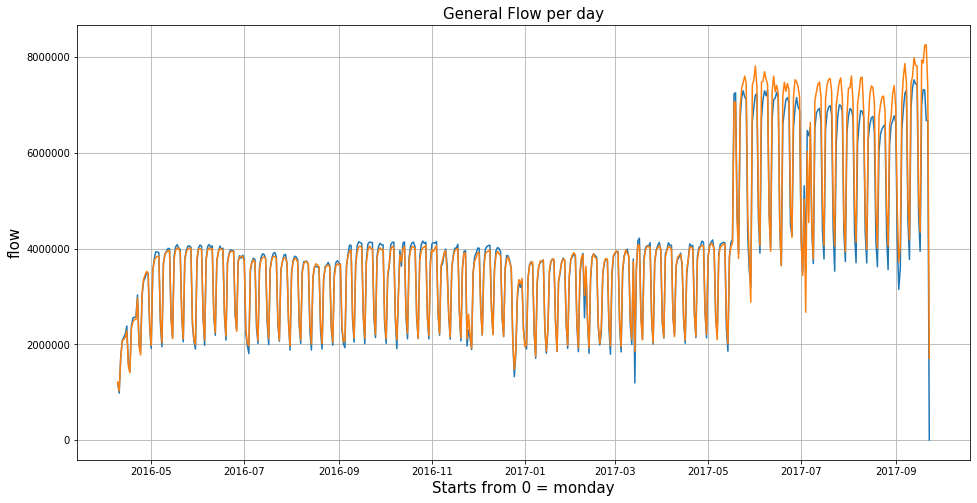

In [0]:
fig = plt.figure(figsize=(16,8))
sns.lineplot(data = flow_per_day[flow_per_day['date'].dt.year >= 2016], x='date', y='flow')
sns.lineplot(data = predicted_flow_per_day[predicted_flow_per_day['date'].dt.year >= 2016], x='date', y='predicted_flow')
plt.title('General Flow per day', size = 15)
plt.xlabel('Starts from 0 = monday', size = 15)
plt.ylabel('flow', size = 15)
plt.grid()
plt.show()

Interessante, olhando pro fluxo por dia como um todo, nosso previsão está visualmente ok.<br>
Dei uma filtrada pra visualizar melhor mas ja verifiquei as campanhar que acabam antes de 2016 e também seguem o mesmo padrão.

Vamos olhar como foram as previsões individuais de 10 campanhas por dia.

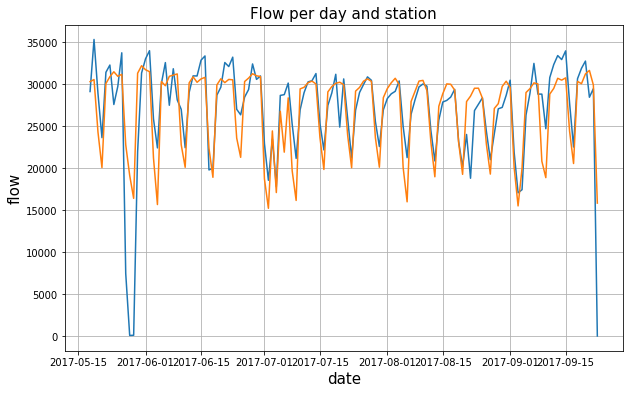

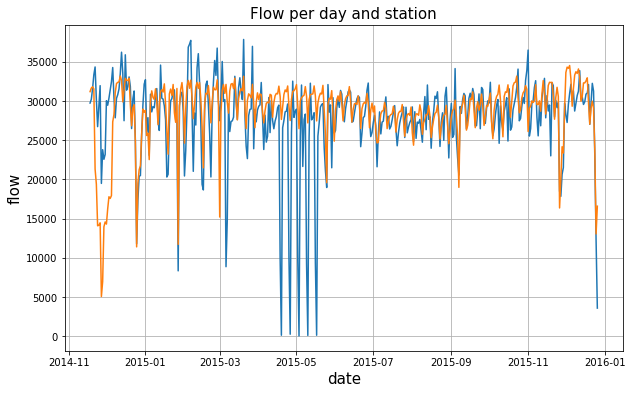

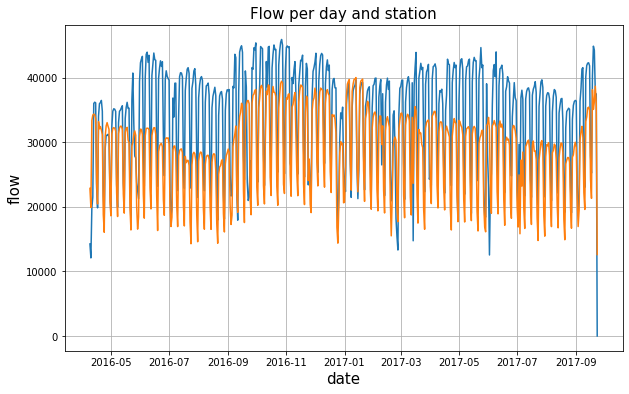

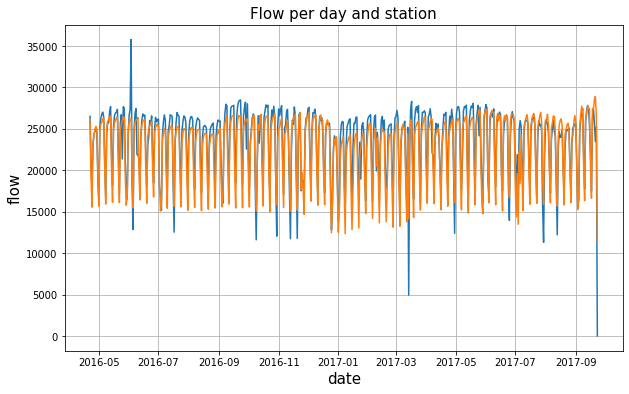

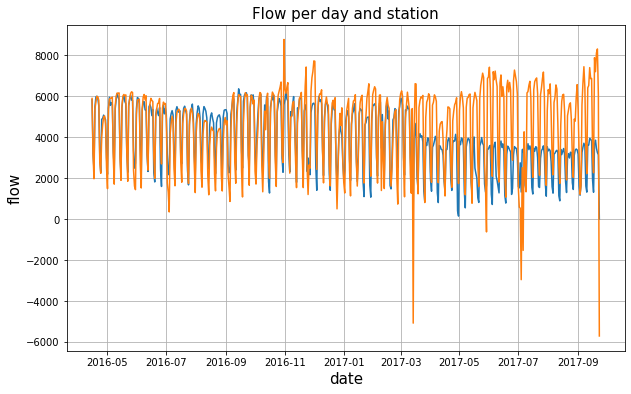

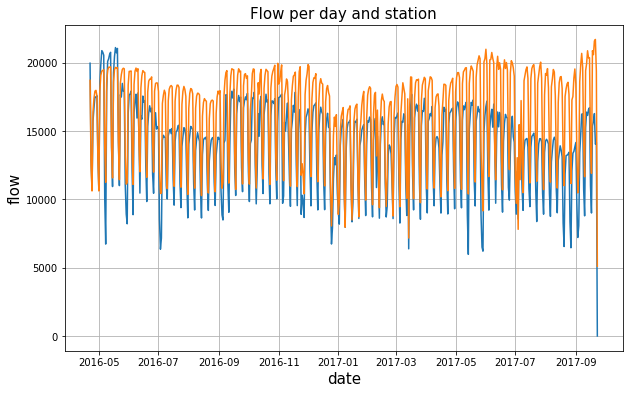

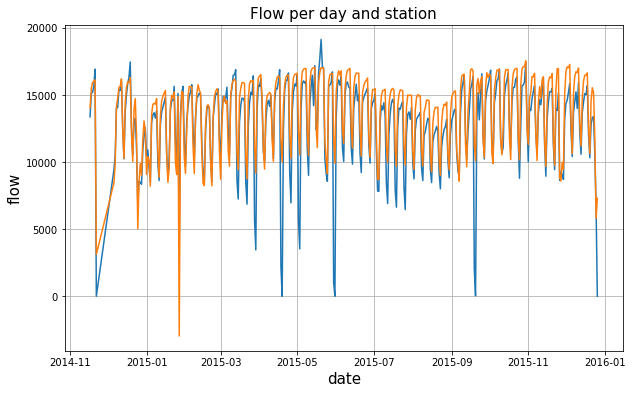

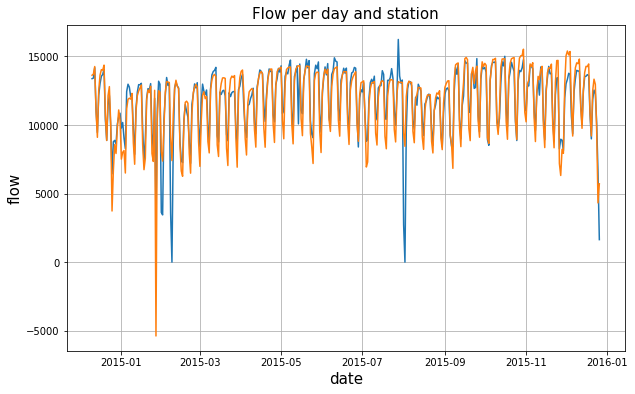

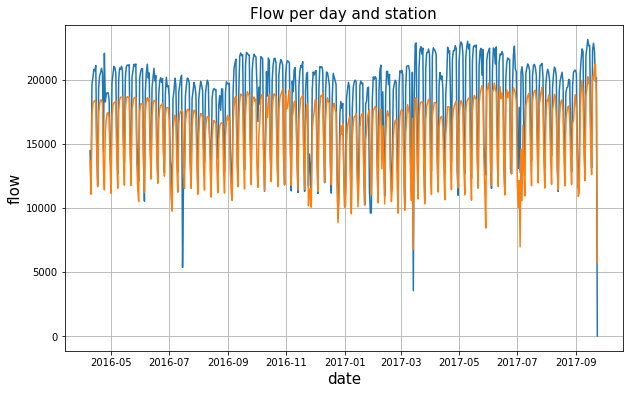

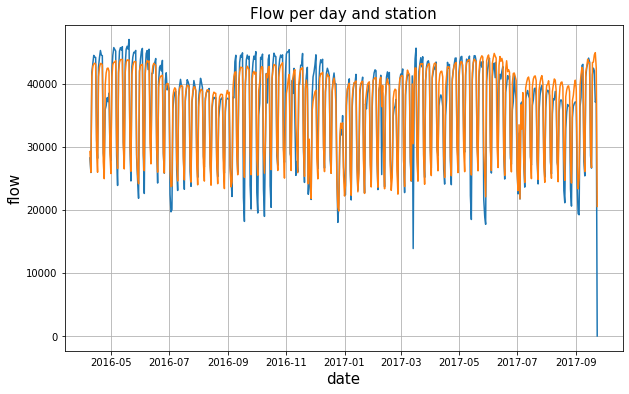

In [0]:
for i in range(1,11):

  fig = plt.figure(figsize=(10,6))
  sns.lineplot(data = df_test_pd_predicted[df_test_pd_predicted['station_index'] == i], x='date', y='flow') ##, hue='rank')
  sns.lineplot(data = df_test_pd_predicted[df_test_pd_predicted['station_index'] == i], x='date', y='predicted_flow') ##, hue='rank')
  plt.title('Flow per day and station', size = 15)
  plt.xlabel('date', size = 15)
  plt.ylabel('flow', size = 15)
  plt.grid()
  plt.show()

É, vemos que o modelo está longe de ser extremamente eficiente (perfeito não existe). <br>
Mas entendo que ele funcionou, podemos observar que em até alguns pontos que fogem do fluxo diário "tradicional" foram entendidos pelo modelo.

É isso, obrigado.

Vitor Rosa.